In [1]:
import numpy as np

x1 = np.linspace(0, 1, 21)
x2 = x1
x3 = np.concatenate((np.linspace(0.35, 0.5, 6, endpoint=False), np.linspace(0.5, 0.55, 5, endpoint=False), np.linspace(0.55, 0.75, 9)))
x4 = x3
x5 = np.linspace(0.35, 0.52, 18)
x6 = np.concatenate((np.array([0.35]), np.linspace(0.37, 0.53, 17)))

y1 = np.array([13.4, 13.5, 14.3, 22.9, 40.4, 81.4, 209, 568, 1260, 2500, 2630, 1800, 765, 255, 114, 53.2, 27.8, 16.8, 14.5, 13.8, 13.5])
y2 = np.array([16, 17.6, 21.8, 194, 598, 1160, 1880, 3640, 6000, 5880, 4020, 2000, 875, 333, 142, 54, 29.6, 19, 16.5, 15.4, 14.3])
y3 = np.array([13.5, 14.4, 15.8, 21.1, 127, 384, 1100, 1410, 1590, 1590, 1430, 1170, 478, 147, 42, 18.4, 16.4, 14.8, 14, 13.6])
y4 = np.array([14, 14.6, 15.6, 18.8, 35.7, 116, 428, 655, 960, 1280, 1580, 1710, 1460, 613, 188, 57, 20, 16.7, 15.1, 14.2])
y5 = np.array([17.9, 20.9, 27, 44.5, 89, 230, 820, 2300, 4300, 4400, 2400, 660, 172, 58, 24.8, 17.6, 16.7, 16.5])
y6 = np.array([26, 54, 106, 210, 440, 960, 1810, 2770, 3440, 2510, 1370, 580, 275, 148, 58, 26, 19.2, 17.7])



In [2]:
from scipy.optimize import curve_fit

# Define the Gaussian function
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

# Assuming x1, y1, ..., x6, y6 are defined
x_values = [x1, x2, x3, x4, x5, x6]
y_values = [y1, y2, y3, y4, y5, y6]

# Store the fit parameters for each set
fit_params = []

for x, y in zip(x_values, y_values):
    # Initial guess for the parameters
    initial_guess = [np.mean(x), np.max(y), np.std(x)]
    
    # Perform the curve fit
    params, params_covariance = curve_fit(gaussian, x, y, p0=initial_guess)
    
    fit_params.append(params)

# fit_params now contains the fitted parameters for each set

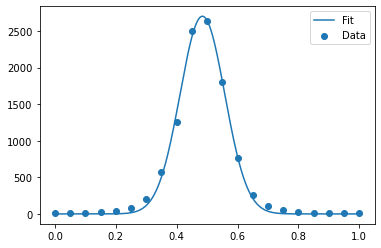

Fitted 1/e^2 diameter: 6.21 mm
Fitted amplitude: 2700 mV


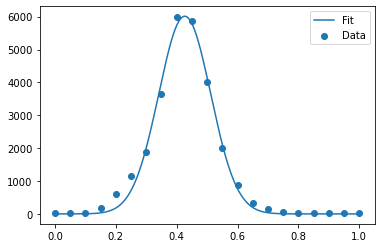

Fitted 1/e^2 diameter: 7.22 mm
Fitted amplitude: 6012 mV


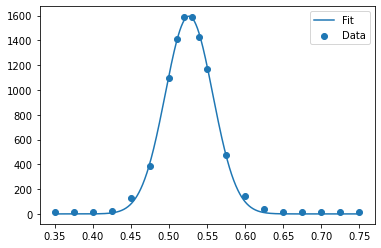

Fitted 1/e^2 diameter: 2.64 mm
Fitted amplitude: 1595 mV


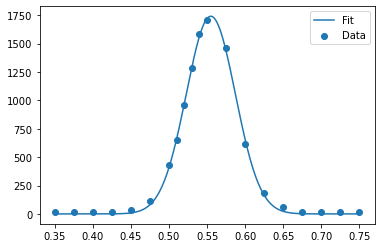

Fitted 1/e^2 diameter: 2.73 mm
Fitted amplitude: 1740 mV


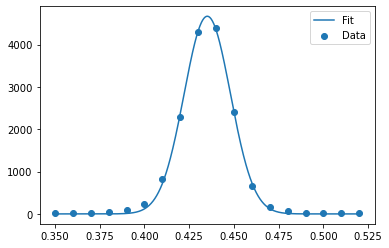

Fitted 1/e^2 diameter: 1.1 mm
Fitted amplitude: 4668 mV


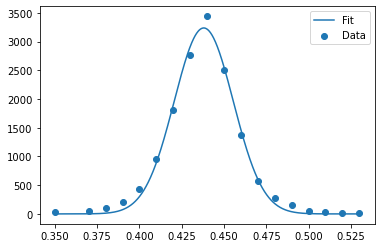

Fitted 1/e^2 diameter: 1.48 mm
Fitted amplitude: 3236 mV


In [7]:
import matplotlib.pyplot as plt

for x, y, params in zip(x_values, y_values, fit_params):
    plt.figure()  # Create a new figure for each plot
    
    # Plot the original data
    plt.scatter(x, y, label='Data')
    
    # Generate a range of x values for the fitted function
    x_fit = np.linspace(min(x), max(x), 1000)
    
    # Compute the fitted y values
    y_fit = gaussian(x_fit, *params)
    
    # Plot the fitted function
    plt.plot(x_fit, y_fit, label='Fit')
    
    plt.legend()  # Add a legend
    plt.show()  # Display the plot
    # Compute the 1/e^2 diameter and amplitude
    mean, amplitude, standard_deviation = params
    diameter = 2 * np.sqrt(2 * np.log(2)) * standard_deviation
    
    # Convert diameter to centimeters and round to 2 decimal places
    diameter_cm = round(diameter * 25.4, 2)
    
    # Round amplitude to the nearest integer
    amplitude_mv = round(amplitude)
    
    print(f'Fitted 1/e^2 diameter: {diameter_cm} mm')
    print(f'Fitted amplitude: {amplitude_mv} mV')